In [1]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import os
import datetime
import matplotlib.pyplot as plt
import joblib
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb
from sklearn.model_selection import KFold

In [70]:
orig_data=pd.read_excel('OLSP_T.xlsx')  #'D:\坚果云\合作 Projects\秦奔 Project\Big data project\Geobarameter\cpxthermobarameter\P4.xlsx'
orig_data 

,T,SiO2_Ol,TiO2_Ol,Al2O3_Ol,Cr2O3_Ol,FeOt_Ol,MnO_Ol,MgO_Ol,CaO_Ol,Na2O_Ol,SiO2_Sp,TiO2_Sp,Al2O3_Sp,Cr2O3_Sp,FeOt_Sp,MnO_Sp,MgO_Sp,CaO_Sp,Na2O_Sp,Label
0,940,40.180000,0.04,0.030000,0.01,9.520000,0.14,50.140000,0.09,NaN,0.260000,0.320000,21.420000,10.710000,47.020000,0.17,19.390000,1.200000,0.010000,9
1,900,37.070000,NaN,0.000000,0.02,4.640000,NaN,59.010000,0.04,NaN,0.780000,0.060000,60.840000,9.890000,0.480000,NaN,29.860000,0.420000,NaN,9
2,900,40.800000,NaN,0.030000,0.18,8.640000,NaN,50.600000,0.08,NaN,0.680000,0.640000,37.870000,32.780000,10.480000,NaN,19.960000,0.280000,NaN,9
3,940,41.824512,0.00,0.000000,0.00,5.605066,NaN,52.030260,0.00,0.255753,0.425351,0.297746,43.013611,27.722246,8.326244,NaN,19.895789,0.000000,0.000000,9
4,850,43.519904,0.00,0.414048,0.00,5.068343,NaN,50.997705,0.00,0.000000,0.565242,0.239509,28.396244,42.929680,9.570799,NaN,17.905729,0.105384,0.287411,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,1370,40.170000,0.02,0.100000,0.09,7.310000,0.11,51.570000,0.26,0.010000,0.260000,0.180000,36.780000,32.340000,9.100000,0.11,20.890000,0.110000,0.010000,14
86,1350,40.700000,NaN,NaN,0.11,9.100000,0.08,49.700000,0.27,NaN,0.300000,0.210000,56.600000,13.000000,8.100000,0.04,21.300000,0.100000,NaN,14
87,1370,40.900000,NaN,NaN,0.16,8.810000,0.07,49.800000,0.27,NaN,0.340000,0.200000,49.600000,21.000000,8.500000,0.05,20.200000,0.060000,NaN,14
88,1385,40.800000,NaN,NaN,0.22,8.400000,0.11,50.100000,0.32,NaN,0.300000,0.210000,41.300000,29.800000,9.150000,0.05,19.160000,0.080000,NaN,14


In [71]:
# Separate features and labels
X = orig_data.drop(["T",'Label'], axis=1).copy()
y = orig_data["T"]

In [72]:
#重复 所有数据
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, r2_score, make_scorer, f1_score, recall_score, precision_score
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np 

list11 = []
list21 = []

repeat = 1000
for i in range(0,repeat): 
    # stratified random sampling based on the results of KMeans Clustering
    split_xgb = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=None)
    # divide augmented X and y into training and testing data
    for train_index, test_index in split_xgb.split(orig_data, orig_data["Label"]):
        #train : test = 4 : 1
        X_train = X.loc[train_index]
        X_test = X.loc[test_index] 
        y_train = y.loc[train_index]
        y_test = y.loc[test_index]
    
    model_xgb = XGBRegressor(        
        base_score = 0,
        booster ='gbtree',
        objective='reg:squarederror',
        colsample_bylevel = 1,
        colsample_bynode = 1,
        max_delta_step = 0,
        reg_alpha = 0.7,
        reg_lambda = 0.2,
        #'scale_pos_weight':[1],
        tree_method = 'exact',
        validate_parameters = 9,
        num_parallel_tree = 2,
        colsample_bytree = 0.8,
        eta = 0.3,    #0.1
        #silent: 
        subsample = 0.8,
        max_depth = 9,
        min_child_weight = 20,
        gamma = 0.5,
        n_estimators = 100,
        random_state = 10,
        #'num_boost_round':[50],
        #'early_stopping_rounds': [50]
        )
    model_xgb.fit(X_train,y_train)
    
    #grid = GridSearchCV(estimator=xgb, param_grid=xgb_params,scoring='r2', cv=5,n_jobs=8).fit(X_train,y_train)
    
    predict_train = model_xgb.predict(X_train)
    predict_test = model_xgb.predict(X_test)
    
    #print(r2_score(y_test, predict_test))
    list11.append(r2_score(y_test, predict_test))
    
    #grid_ = grid.best_estimator_
    importance = model_xgb.feature_importances_
    list21.append(importance)
    
print(list11)
print(list21)

[0.4625297171278481, 0.6298742655242826, 0.38007971610415237, 0.5401384601274648, 0.3780327535988256, 0.3915768905429834, 0.3629544864957365, 0.639295817362771, 0.5781799369042778, 0.6985911745581037, 0.5427128038442213, 0.4438506155449622, 0.5217235733892416, 0.5779060417059865, 0.5682918711152072, 0.6883145665863342, 0.6002482457948085, 0.6869296308599508, 0.4698782317804211, 0.5576256992191323, 0.45796185270423184, 0.34346593719926866, 0.6769026595437806, 0.5510679007217556, 0.4594676889790733, 0.6693404352747288, 0.6089699139399753, 0.613231356755161, 0.04354664404770414, 0.6084296401611107, 0.5905782620774485, 0.638901152689832, 0.6803386037290113, 0.45413452762042195, 0.3579286727865819, 0.4923583229867746, 0.45258222170138107, 0.25713177146227373, 0.6433738694647502, 0.35464928598778134, 0.4752063153296239, 0.3730888154926759, 0.6576947119730971, 0.45852760536925175, 0.658238446556773, 0.4681757350316669, 0.5700744906477302, 0.5866388225148793, 0.48184401599718774, 0.69879131865

[array([0.07273886, 0.0512755 , 0.02615432, 0.03348254, 0.05532478,
       0.08708303, 0.03329247, 0.1780677 , 0.01644398, 0.02638052,
       0.04760357, 0.02291103, 0.03221514, 0.07903578, 0.04480262,
       0.07645482, 0.06280318, 0.05393019], dtype=float32), array([0.02577253, 0.0873895 , 0.02846523, 0.02302248, 0.05486669,
       0.06084013, 0.03985536, 0.23703305, 0.        , 0.03904029,
       0.05146647, 0.01918684, 0.03663651, 0.09976529, 0.05188554,
       0.0464154 , 0.07373708, 0.02462153], dtype=float32), array([0.05841741, 0.02410157, 0.02616817, 0.05157257, 0.03196973,
       0.11372788, 0.04184873, 0.215476  , 0.04570115, 0.03167898,
       0.05087718, 0.01355314, 0.02283999, 0.04628953, 0.04316268,
       0.03911332, 0.05631851, 0.08718339], dtype=float32), array([0.03941929, 0.03367786, 0.04666981, 0.02830506, 0.06204901,
       0.10364613, 0.03393168, 0.24504231, 0.01880512, 0.04682294,
       0.04347282, 0.0175779 , 0.03635186, 0.06540062, 0.04679368,
       0.045180

In [73]:
df11 = pd.DataFrame(list11)
df11

,0
0,0.462530
1,0.629874
2,0.380080
3,0.540138
4,0.378033
...,...
995,0.608182
996,0.496581
997,0.546829
998,0.542981


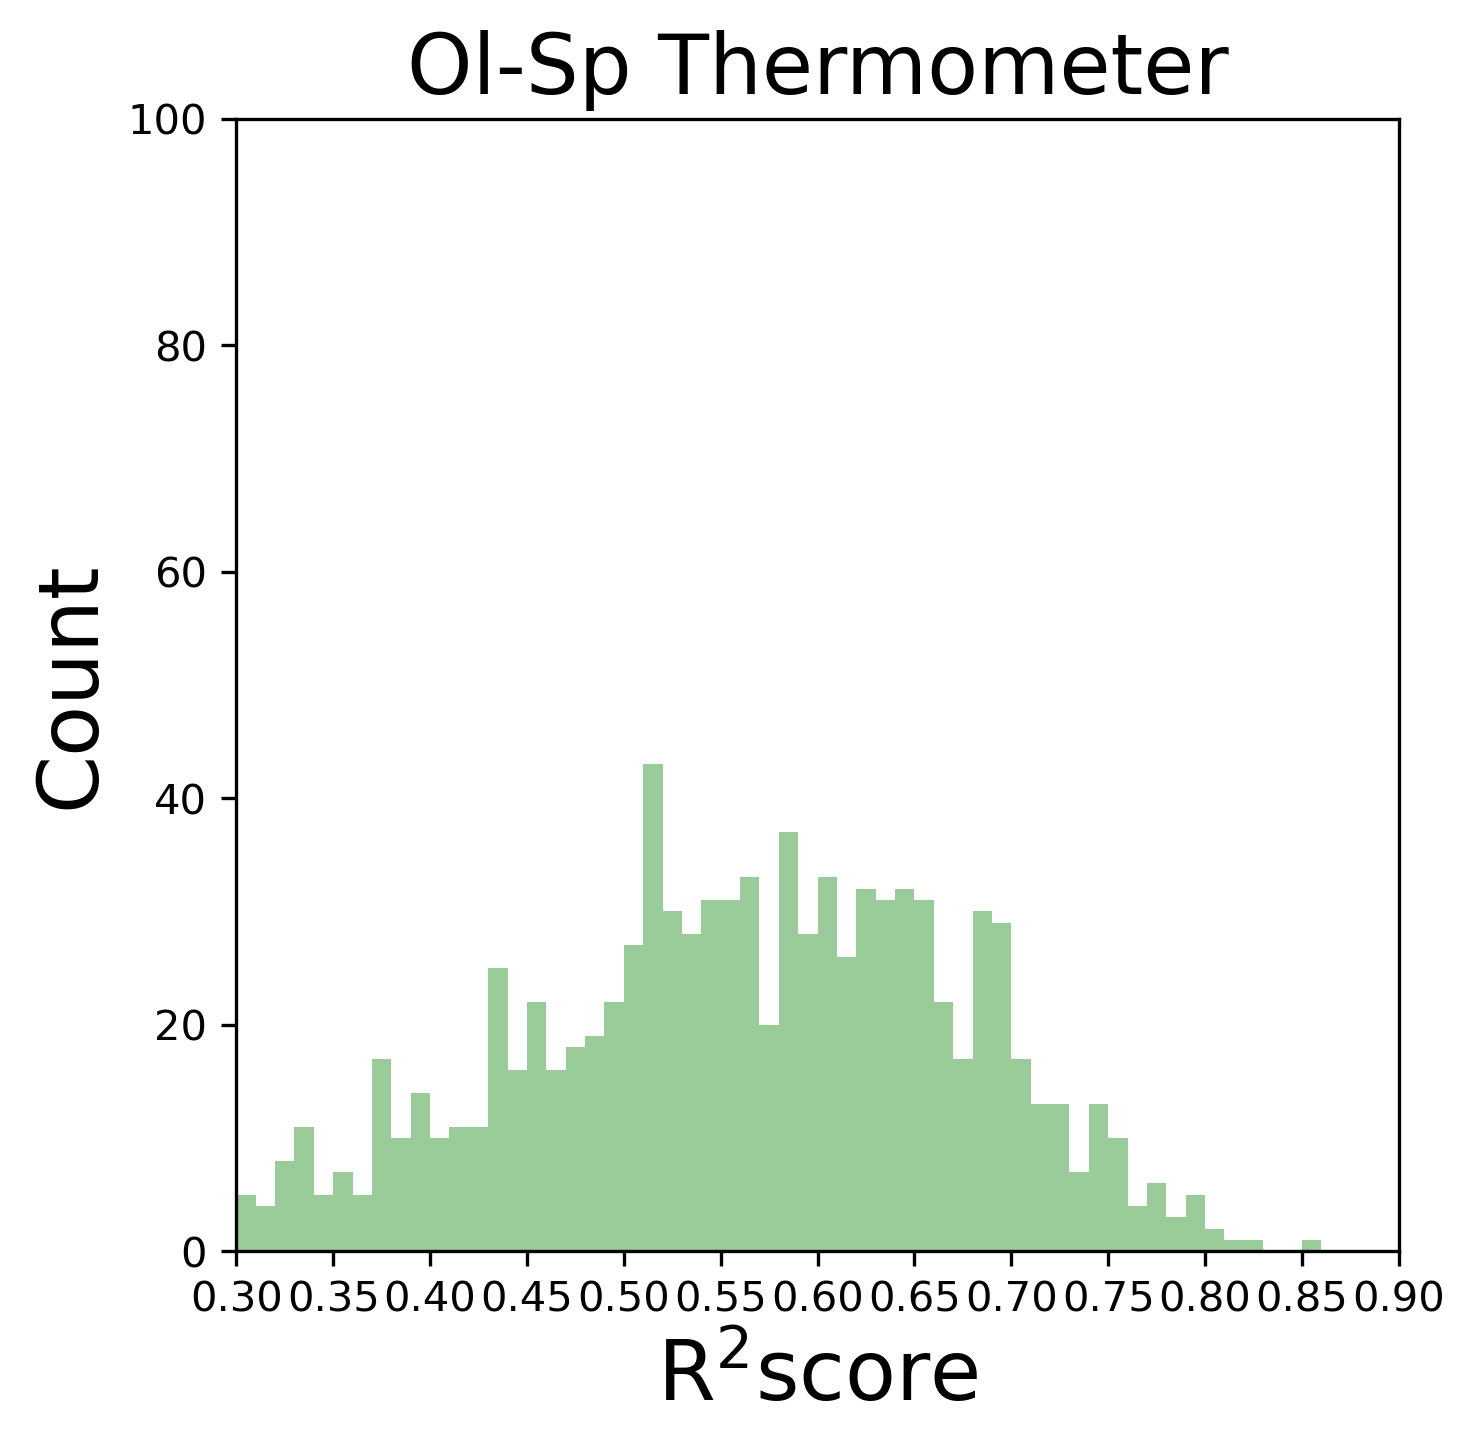

In [76]:
# 投分布图
import seaborn as sns
plt.figure(figsize=(5,5),dpi=300)

ax1 = plt.subplot(111)
ax1 = sns.distplot(df11, bins = np.arange(0.3,0.9,0.01), kde = False, hist_kws = {'color':'green'})
ax1.set_xlim((0.3,0.9))
ax1.set_xticks([0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9])   #,0.95,1
ax1.set_ylim((0,100))
#plt.legend()
ax1.set_ylabel('Count',size=20)
ax1.set_xlabel('$\mathregular{R^2 score}$',size=20)

plt.subplots_adjust(wspace=0, hspace=0)
plt.title("Ol-Sp Thermometer",size=20)
plt.show()

In [14]:
df21 = pd.DataFrame(list21)
df21

,0,1,2,3,4,5,6,7,8
0,0.028453,0.055291,0.052927,0.065060,0.125544,0.103776,0.266338,0.204631,0.097981
1,0.031252,0.058914,0.051603,0.062330,0.101170,0.078698,0.258054,0.210150,0.147830
2,0.037668,0.059985,0.055823,0.070796,0.086837,0.098384,0.306956,0.184149,0.099402
3,0.036030,0.049856,0.050843,0.069547,0.104897,0.051400,0.362826,0.171170,0.103432
4,0.034797,0.079220,0.044478,0.072012,0.087848,0.053305,0.245061,0.222895,0.160385
...,...,...,...,...,...,...,...,...,...
995,0.037918,0.066833,0.045371,0.069189,0.077174,0.084260,0.337399,0.156286,0.125568
996,0.039097,0.062642,0.053470,0.076477,0.085815,0.061412,0.267201,0.179384,0.174501
997,0.033079,0.069096,0.045078,0.065870,0.114571,0.076020,0.316697,0.184691,0.094899
998,0.042340,0.043549,0.046963,0.069499,0.106857,0.051082,0.333198,0.196336,0.110176


TypeError: _set_ticklabels() missing 1 required positional argument: 'labels'

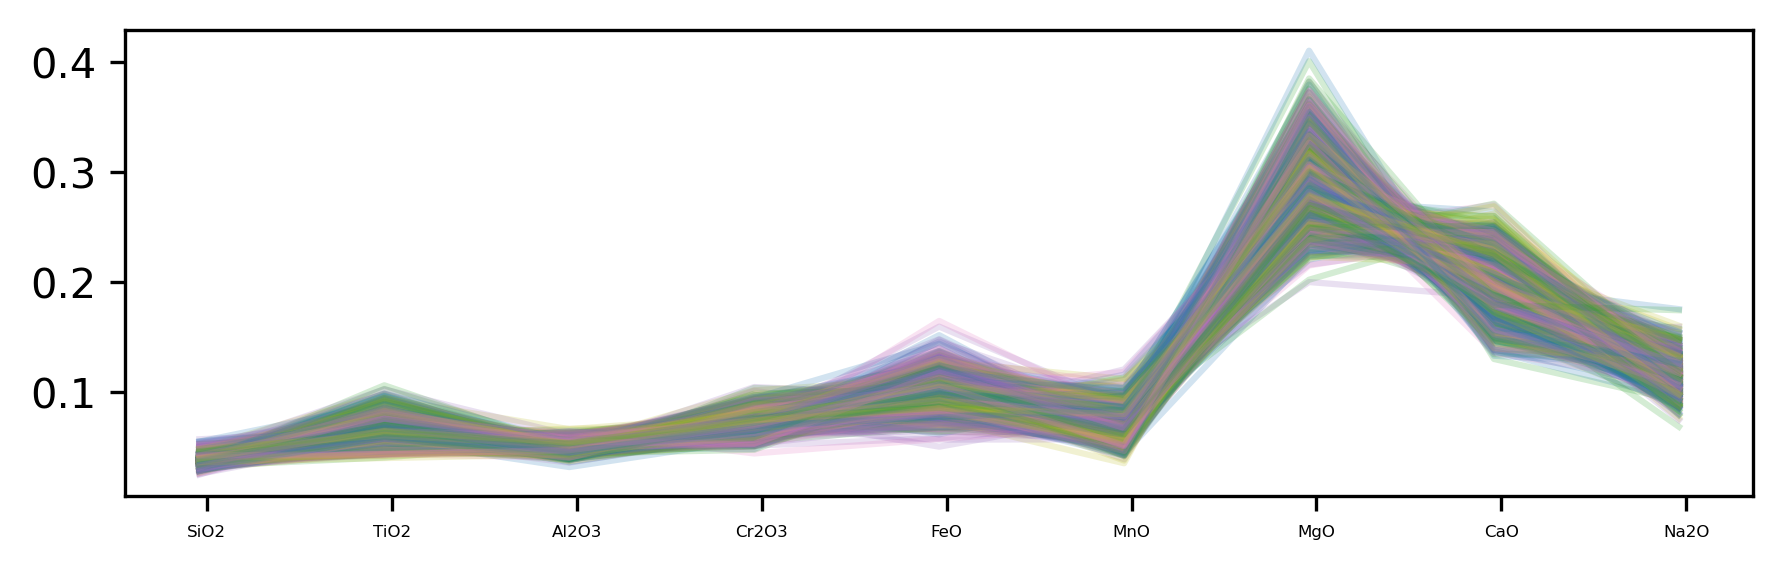

In [15]:
plt.figure(figsize=(7,7),dpi=300)
f51 = plt.subplot(313)
width=0.4

feature_name = X.columns
a = np.arange(len(importance))
for i in range(len(df21)):
    b = df21.iloc[i]
    f51.plot(a,b,width,alpha=0.2)
    
f51.set_xticks(a+width/10)
f51.set_xticklabels(feature_name, minor=False, fontsize=4)
f51.set_yticklabels( minor=False, fontsize=5)
#f51.set_title('Feature importance in Xgboost-undegas and EMORB-CO2-label-log', fontsize=8)
f51.set_ylabel('Relative importance', fontsize=7)
f51.set_xlabel('feature', fontsize=7) 
plt.show()